## Optional Lab: Model Evaluation and Selection

Quantifying a learning algorithm's performance and comparing different models are some of the common tasks when applying machine learning to real world applications. In this lab, we will practice doing these using the tips shared in class. Specifically, we will:

* split datasets into training, cross validation, and test sets
* evaluate regression and classification models
* add polynomial features to improve the performance of a linear regression model
* compare several neural network architectures

### Imports and Lab Setup
First, you will import the packages needed for the tasks in this lab. We also included some commands to make the outputs later more readable by reducing verbosity and suppressing non-critical warnings.

In [23]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

np.set_printoptions(precision=2)

# suppress warnings
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

#### Prepare Data

shape of X_train: (50, 1)
shape of X_synthetic: (50, 2)
shape of W_syntehtic: (1, 2)
Contents of transposed W_syntehtic: [[2]
 [1]]
shape of Y_train: (50, 1)


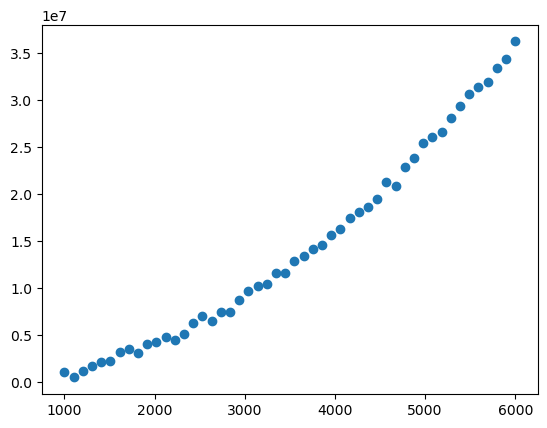

In [2]:
# Generate sizes - 1000 to 6000 sqft each 100 sqft apart
x_train = np.linspace(1000, 6000, 50)

# Make it 2D so that we can use it in library utility functions like below
x_train = np.expand_dims(x_train, axis=1)

# Prepare polynomial features for the training data and concatenate it with the original data
X_synthetic = np.concatenate((x_train, x_train**2), axis=1)
# Alternatively, we can use PolynomialFeatures from sklearn as shown below
# polynomial_mapper = PolynomialFeatures(degree=2, include_bias=False)
# poly_features = polynomial_mapper.fit_transform(X_train)
# print(poly_features.shape)

print(f"shape of X_train: {x_train.shape}")
print(f"shape of X_synthetic: {X_synthetic.shape}")

# Prepare synthetic weights to prepare the synthetic prices and change it to a 2D array
W_syntehtic = np.array([2, 1]).reshape(-1, 2)
print(f"shape of W_syntehtic: {W_syntehtic.shape}")
print(f"Contents of transposed W_syntehtic: {W_syntehtic.T}")

# Generate synthetic prices - with quadratic relationship - 2x + 1x^2
y_train = np.matmul(X_synthetic, W_syntehtic.T)
print(f"shape of Y_train: {y_train.shape}")

# Add impurity to the prices so that it doesn't give a zero cost function when we predict the prices.  
y_train = y_train + np.random.normal(0, 350000, x_train.shape)

# Plot training data
plt.scatter(x_train, y_train)



##### Break data set - training, cross validation & test 

shape of x_train: (30, 1)
shape of x_cv: (10, 1)


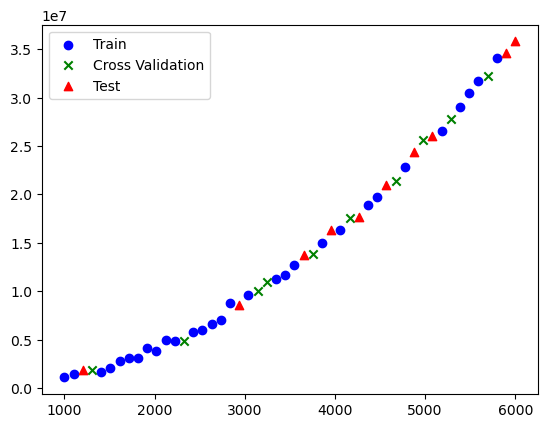

In [152]:
# Break the whole data set into three parts - training set - 60% , cv(cross-validation) set - 20% and test set - 20%
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.4, random_state=1)
x_cv, x_test, y_cv, y_test = train_test_split(x_validate, y_validate, test_size=0.5, random_state=1)
print(f"shape of x_train: {x_train.shape}")
print(f"shape of x_cv: {x_cv.shape}")

# Plot training, cv and test data
fig, ax = plt.subplots()
ax.scatter(x_train, y_train, color='blue', label='Train')
ax.scatter(x_cv, y_cv, color='green', marker='x', label='Cross Validation')
ax.scatter(x_test, y_test, color='red', marker='^', label='Test')
ax.legend()

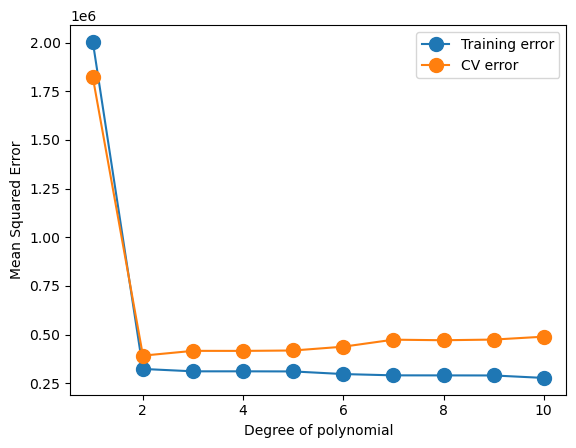

In [176]:
models = []
train_errors = []
cv_errors = []
scalers = []
#degrees = [2]
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for i in range(len(degrees)):
    # Prepare polynomial features 
    poly_feature_creator = PolynomialFeatures(degree=degrees[i], include_bias=True)
    x_train_poly = poly_feature_creator.fit_transform(x_train)
    # print(f"shape of x_polynomialized = {x_train_poly.shape}")
    # print(f"First two elements of x_polynomialized: {x_train_poly[:2]}")

    # Scale the features using z-score normalization with the help of sklearn utility function
    norm_scaler = StandardScaler()
    x_train_norm = norm_scaler.fit_transform(x_train_poly)
    # print(f"shape of x_polynomialized_norm = {x_train_norm.shape}")
    # print(f"First two elements of x_polynomialized_norm: {x_train_norm[:2]}")
    # Store the scaler to use the same one when running this model agaisnt cv and test set for given degree.
    scalers.append(norm_scaler)

    # Train the model with polynomialized and normalized data.
    model = LinearRegression()
    model.fit(x_train_norm, y_train)
    # Store the model for reuse when running this model agaisnt cv and test set for given degree.
    models.append(model)
    
    # Get the model predictions and store the cost function aka mean squared errors for training data.
    y_train_pred = model.predict(x_train_norm)
    mse_train = root_mean_squared_error(y_train, y_train_pred)
    train_errors.append(mse_train)

    # Get the predictions and errors for cv data.
    x_cv_poly = poly_feature_creator.fit_transform(x_cv)
    # NOTE: We are using the same scaler that we used for training data to normalize cv data but we are not fitting it again.
    x_cv_norm = norm_scaler.transform(x_cv_poly) 
    y_cv_pred = model.predict(x_cv_norm)
    mse_cv = root_mean_squared_error(y_cv, y_cv_pred)
    cv_errors.append(mse_cv)
    
    # This plots how well the model predicts the prices for training and cv data.
    # Uncomment this to see the plots. Please note that it will plot for all the degrees.
    # Hence, better to have just one degree in the `degrees' list to see the plot one by one.
    # fig, ax = plt.subplots()
    # ax.scatter(x_train, y_train, color='blue', label='Train', alpha=0.5)
    # ax.scatter(x_cv, y_cv, color='green', marker='x', label='Cross Validation', alpha=0.5)
    # ax.scatter(x_test, y_test, color='red', marker='^', label='Test')
    # ax.scatter(x_train, y_train_pred, color='yellow', label='Train prediction', alpha=0.5)
    # ax.scatter(x_cv, y_cv_pred, color='pink', marker='x', label='CV prediction', alpha=0.5)
    # ax.legend()


plt.plot(degrees, train_errors, label="Training error", marker='o', ms=10)
plt.plot(degrees, cv_errors, label="CV error", marker='o', ms=10)
plt.xlabel("Degree of polynomial")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()
